In [0]:
! pip install kaggle


In [0]:
! mkdir -p ~/.kaggle/
! pwd
! mv kaggle.json ~/.kaggle/

/content


In [0]:
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
path = Config.data_path()/'retinaImages'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/retinaImages')

In [0]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 8.00G/8.01G [01:31<00:00, 104MB/s] 
100% 8.01G/8.01G [01:31<00:00, 93.9MB/s]
 99% 1.49G/1.50G [00:18<00:00, 98.8MB/s]
100% 1.50G/1.50G [00:18<00:00, 86.0MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 49.3MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 8.04MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 28.9MB/s]


In [0]:
! mv sample_submission.csv {path}/
! mv test.csv {path}/
! mv test_images.zip {path}/
! mv train.csv {path}/
! mv train_images.zip {path}/


In [0]:
! unzip -q -n {path}/train_images.zip -d {path}/train_images

In [0]:
! unzip -q -n {path}/test_images.zip -d {path}/test_images

In [0]:
df_train = pd.read_csv(path/'train.csv')
df_train.head()

In [0]:
df_test = pd.read_csv(path/'test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


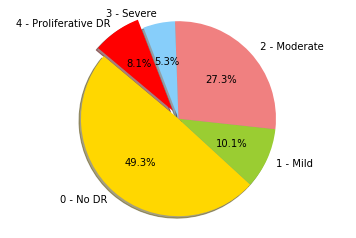

In [1]:
#exploratory analysis


import matplotlib.pyplot as plt
 
# Data to plot
labels = '0 - No DR', '1 - Mild', ' 2 - Moderate', '3 - Severe','4 - Proliferative DR'
sizes = [1805, 370, 999, 193,295]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red'] #magenta
explode = (0, 0, 0, 0,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


# looking at the data set we know that we have almost 50% NO DR cases , this can lead to an model over fitting and given the imbalance in label samples
# it may not be the best representative data set , but as part of our goal from this capstone , we would like to predict Proliferative DR [lable -4] more 
#accuratley than any other , but given the data challenges we decided to predict No DR case with utmost highest accuracy as possible 

In [0]:
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        self.data,self.preds,self.y_true,self.losses,self.ds_type, self.learn = \
                                 learn.data,preds,y_true,losses,ds_type,learn
        self.ds = (self.data.train_ds if ds_type == DatasetType.Train else
                   self.data.test_ds if ds_type == DatasetType.Test else
                   self.data.valid_ds if ds_type == DatasetType.Valid else
                   self.data.single_ds if ds_type == DatasetType.Single else
                   self.data.fix_ds)

    @classmethod
    def from_learner(cls, learn: Learner,  ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None):
        "Gets preds, y_true, losses to construct base class from a learner"
        preds_res = learn.get_preds(ds_type=ds_type, activ=activ, with_loss=True)
        return cls(learn, *preds_res)

    def top_losses(self, k:int=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        
        
class My3_ClassificationInterpretation(Interpretation):
   
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        super(My3_ClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)

    def confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            #self.y_true = self.y_true.float()
            self.y_true = self.y_true.float()
            for i in range(0, self.y_true.shape[0], slice_size):
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size].float()==x[:,None,None].float())).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", slice_size:int=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix(slice_size=slice_size)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(self.data.c)
        plt.xticks(tick_marks, self.data.y.classes, rotation=90)
        plt.yticks(tick_marks, self.data.y.classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)
        if ifnone(return_fig, defaults.return_fig): return fig

    def most_confused(self, min_val:int=1, slice_size:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix(slice_size=slice_size)
        np.fill_diagonal(cm, 0)
        res = [(self.data.classes[i],self.data.classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)


def _learner_interpret(learn:Learner, ds_type:DatasetType=DatasetType.Valid):
    "Create a `ClassificationInterpretation` object from `learner` on `ds_type` with `tta`."
    return ClassificationInterpretation.from_learner(learn, ds_type=ds_type)
Learner.interpret = _learner_interpret





def my_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    #targs = targs.view(-1).long()
    targs = targs.long()
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()


def my_error_rate(input:Tensor, targs:Tensor)->Rank0Tensor:
    "1 - `accuracy`"
    return 1 - my_accuracy(input, targs)





In [0]:
#data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

!cp /root/.fastai/data/retinaImages/train.csv /root/.fastai/data/retinaImages/labels.csv
df = pd.read_csv(path/'labels.csv')
data = ImageDataBunch.from_csv(path, folder='train_images', size=128, suffix='.png', label_delim=' ',
    ds_tfms=get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),num_workers=4)

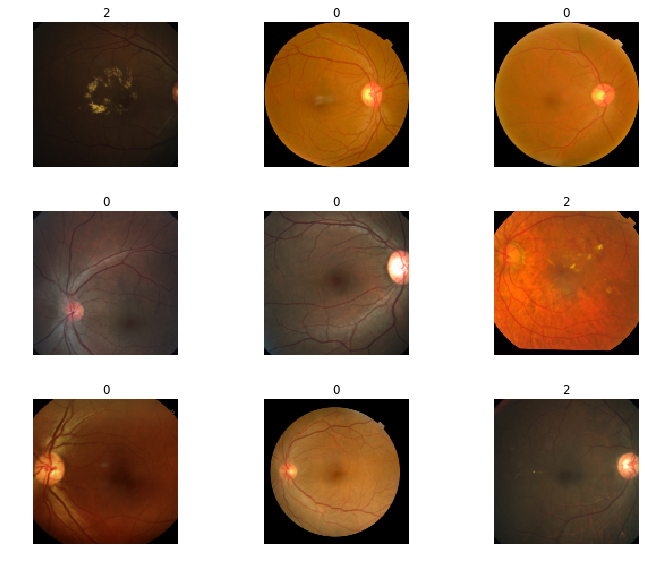

In [0]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)

In [0]:
arch = models.resnet34
#learn = create_cnn(data,models.resnet34, metrics=my_error_rate)
learn = cnn_learner(data, arch, metrics=[my_error_rate])

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,my_error_rate,time
0,0.617785,0.377768,0.539891,08:11
1,0.388946,0.230399,0.532240,08:12
2,0.298033,0.218102,0.549727,08:09
3,0.263041,0.220696,0.545628,08:16


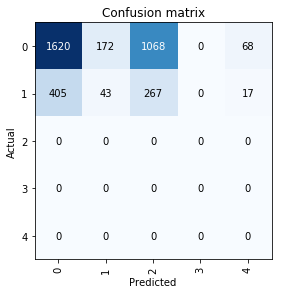

In [0]:
interpreter1 = My3_ClassificationInterpretation.from_learner(learn)
interpreter1.plot_confusion_matrix()

In [0]:
learn.save('stage-1-res34')


In [0]:

learn.unfreeze()
learn.load('stage-1-res34')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


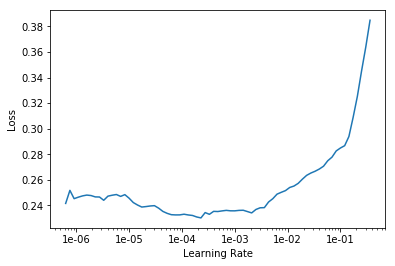

In [0]:
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(5, slice(1e-05,1e-04)) #lr/5))

epoch,train_loss,valid_loss,my_error_rate,time
0,0.233490,0.212880,0.553279,08:15
1,0.223117,0.204636,0.566667,08:10
2,0.216613,0.192616,0.568033,08:15
3,0.209985,0.191162,0.567213,08:21
4,0.203807,0.188169,0.577596,08:22


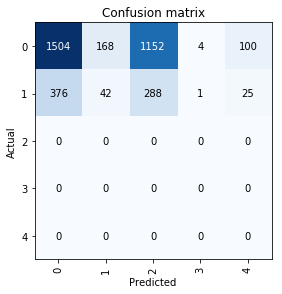

In [0]:
interpreter2 = My3_ClassificationInterpretation.from_learner(learn)
interpreter2.plot_confusion_matrix()

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
! ls -ltr {path}/

total 9975552
-rw-r--r-- 1 root root 8602001734 Sep 10 03:30 train_images.zip
-rw-r--r-- 1 root root 1612694851 Sep 10 03:31 test_images.zip
-rw-r--r-- 1 root root      54948 Sep 10 03:31 train.csv
-rw-r--r-- 1 root root      25072 Sep 10 03:31 test.csv
-rw-r--r-- 1 root root      28938 Sep 10 03:31 sample_submission.csv
drwxr-xr-x 2 root root     135168 Sep 10 03:34 train_images


In [0]:
! ls {path}/train_images/

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='train_images', suffix='.png')
       #.split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
#data classes
#data.c
data.classes
#len(data.classes)

[0, 1, 2, 3, 4]

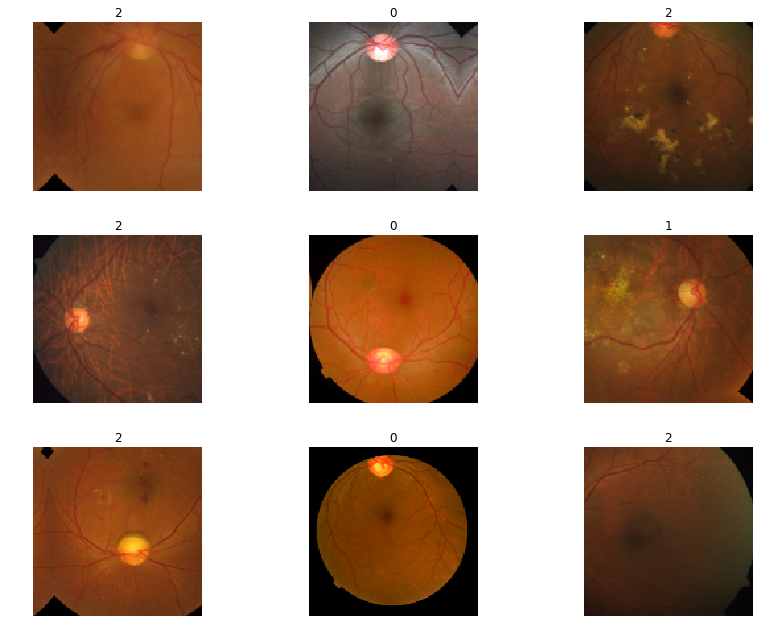

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
#accuracy at threshold of 0.2 , prints accuracy at threshold of 0.2 TODO: check different 0.2 
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
#learn = cnn_learner(data, arch, metrics=[acc_02, f_score]) #commented at 9/9 1530ET
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


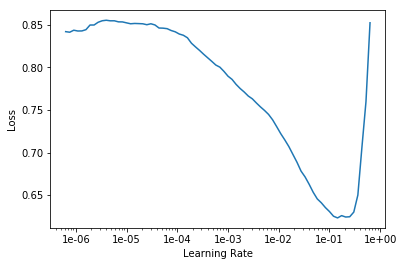

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.02

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.428765,0.282912,0.849180,0.784031,07:55
1,0.297426,0.295167,0.893169,0.780087,07:55
2,0.250858,0.210406,0.901366,0.819932,07:55
3,0.215954,0.201105,0.890984,0.838245,08:04
4,0.195271,0.198665,0.899727,0.839676,07:59


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn

In [0]:
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        self.data,self.preds,self.y_true,self.losses,self.ds_type, self.learn = \
                                 learn.data,preds,y_true,losses,ds_type,learn
        self.ds = (self.data.train_ds if ds_type == DatasetType.Train else
                   self.data.test_ds if ds_type == DatasetType.Test else
                   self.data.valid_ds if ds_type == DatasetType.Valid else
                   self.data.single_ds if ds_type == DatasetType.Single else
                   self.data.fix_ds)

    @classmethod
    def from_learner(cls, learn: Learner,  ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None):
        "Gets preds, y_true, losses to construct base class from a learner"
        preds_res = learn.get_preds(ds_type=ds_type, activ=activ, with_loss=True)
        return cls(learn, *preds_res)

    def top_losses(self, k:int=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."


In [0]:
  class My3_ClassificationInterpretation(Interpretation):
   
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        super(My3_ClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)

    def confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            #self.y_true = self.y_true.float()
            self.y_true = self.y_true.float()
            for i in range(0, self.y_true.shape[0], slice_size):
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size].float()==x[:,None,None].float())).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", slice_size:int=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix(slice_size=slice_size)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(self.data.c)
        plt.xticks(tick_marks, self.data.y.classes, rotation=90)
        plt.yticks(tick_marks, self.data.y.classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)
        if ifnone(return_fig, defaults.return_fig): return fig

    def most_confused(self, min_val:int=1, slice_size:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix(slice_size=slice_size)
        np.fill_diagonal(cm, 0)
        res = [(self.data.classes[i],self.data.classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)


def _learner_interpret(learn:Learner, ds_type:DatasetType=DatasetType.Valid):
    "Create a `ClassificationInterpretation` object from `learner` on `ds_type` with `tta`."
    return ClassificationInterpretation.from_learner(learn, ds_type=ds_type)
Learner.interpret = _learner_interpret

In [0]:
#algorithm mistakes 
interpreter = My3_ClassificationInterpretation.from_learner(learn)
interpreter.most_confused()


[('0', '2', 1128),
 ('1', '0', 361),
 ('1', '2', 282),
 ('0', '1', 196),
 ('0', '4', 140),
 ('1', '4', 35),
 ('0', '3', 20),
 ('1', '3', 5)]

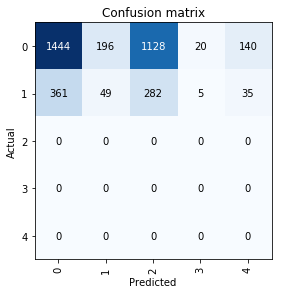

In [0]:
#confusion matrix

#interp = ClassificationInterpretation.from_learner(learn)
#losses,idxs = interp.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)
interpreter1 = My3_ClassificationInterpretation.from_learner(learn)
interpreter1.plot_confusion_matrix()
#losses,idxs = interpreter1.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)

Fine Tuning :

In [0]:
learn.unfreeze()

In [0]:
#learn.lr_find()
#learn.recorder.plot()


In [0]:
learn.fit_one_cycle(5, slice(1e-4,1e-3)) #lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.654607,0.494565,0.399454,0.619956,08:16
1,0.506715,0.276120,0.708743,0.781784,08:18
2,0.353571,0.219865,0.865574,0.843539,08:18
3,0.261225,0.189524,0.887705,0.860493,08:22
4,0.213061,0.184695,0.888251,0.858867,08:20


In [0]:
learn.save('stage-2-rn50')

In [0]:
! pwd

/content


In [0]:
#confusion matrix

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)